In [8]:
import os
from glob import glob
from pathlib import Path
from opensoundscape.annotations import BoxedAnnotations

# Define the paths at the beginning
raven_files_path = r"E:\Bumblebee_Recognizer\Data\TundraBUZZ_Annotations\testing_data_raven\*.txt"
audio_files_path = r"E:\Bumblebee_Recognizer\Data\TundraBUZZ_RawAudio\testing_data\*.wav"
# Define the full path to the output directory
output_path = r"E:\Bumblebee_Recognizer\Data\Output_annotations\\"




# Make a list of all of the selection table files
test_files_raven = sorted(glob(raven_files_path))

# Debugging: print the absolute path and check if any files were found
print("Looking for Raven files in:", os.path.abspath(raven_files_path))
print("Raven files found:", test_files_raven)

# Create a list of audio files, one corresponding to each Raven file 
# (Audio files have the same names as selection files with a different extension)
test_audio_files = sorted(glob(audio_files_path))
print("Audio files found:", test_audio_files)

# Ensure that the Raven files were found
if not test_files_raven:
    print(f"No Raven files found at {raven_files_path}. Please check the directory.")
else:
    # Create a dataframe of annotations
    annotations = BoxedAnnotations.from_raven_files(
        test_files_raven,
        "Annotation",
        test_audio_files, 
        keep_extra_columns=['Selection','View', 'Channel','Begin Time (s)', 
                            'End Time (s)', 'Low Freq (Hz)', 'High Freq (Hz)', 'Annotation']
    )

    # Access the underlying DataFrame and save it
    annotations_data = annotations.df
    # Save the DataFrame
    annotations_data.to_csv(output_path + "annotations_test_4.csv") 

    # Parameters to use for label creation
    clip_duration = 0.3  # clip length (s)
    clip_overlap = 0.15  # clip overlap (s)
    min_label_overlap = 0.07  # 0.07 s of annotated call must be included to be considered "positive"
    min_label_fraction = 0.8  # OR 80% of annotated call must be included
    species_of_interest = ["BUZZ"]  # matches annotation label

    # Create dataframe of one-hot labels
    clip_labels = annotations.clip_labels(
        clip_duration=clip_duration,
        clip_overlap=clip_overlap,
        min_label_overlap=min_label_overlap,
        min_label_fraction=min_label_fraction,
        class_subset=species_of_interest  # You can comment this line out if you want to include all species.
    )

    # Access the underlying DataFrame and save it
    clip_labels.to_csv(output_path + "clip_labels_test_4.csv")

Looking for Raven files in: E:\Bumblebee_Recognizer\Data\TundraBUZZ_Annotations\testing_data_raven\*.txt
Raven files found: ['E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ4_20240701_233000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ4_20240702_033000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ4_20240702_050000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ4_20240702_080000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ5_20240701_140000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ5_20240701_180000.Table.1.selections.txt', 'E:\\Bumblebee_Recognizer\\Data\\TundraBUZZ_Annotations\\testing_data_raven\\ARUQ5_20240810_100000.Table.1.selections.txt']
Audio f

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# ----------------------
# Set paths
# ----------------------
dataset_path = Path("E:/Bumblebee_Recognizer/Data/Output_annotations")

# Load test set (true labels)
test_set_2 = pd.read_csv(dataset_path / "clip_labels_test_4.csv", index_col=[0, 1, 2])  # file, start_time, end_time

# Load and combine prediction files
prediction_files = sorted(glob(str(dataset_path / "predict_score_clips_test_set_3.csv")))
prediction_dfs = [pd.read_csv(f, index_col=[0, 1, 2]) for f in prediction_files]
predictions = pd.concat(prediction_dfs)

# Binarize predictions using your threshold
threshold = 8
predictions['Binary_Predictions'] = (predictions['BUZZ'] > threshold).astype(int)

# Merge test set with predictions
merged_df = pd.merge(test_set_2, predictions, left_index=True, right_index=True, how='inner')

# Rename columns for clarity
merged_df.rename(columns={'BUZZ_x': 'buzz_present', 'BUZZ_y': 'predict_score', 'Binary_Predictions': 'binary_predictions'}, inplace=True)

# Save merged file if needed
merged_df.to_csv(dataset_path / "predictions_fully_merged.csv")

In [ ]:
# ----------------------
# Evaluation metrics
# ----------------------
actual = merged_df['buzz_present'].astype(int)
predicted = merged_df['binary_predictions']
score = merged_df['predict_score']

# Confusion matrix
cm = confusion_matrix(actual, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['absent', 'present'])
disp.plot()
plt.show()

# Precision, Recall, F1
print("f1:", f1_score(actual, predicted))
print("precision:", precision_score(actual, predicted))
print("recall:", recall_score(actual, predicted))

# ----------------------
# Score distribution histogram
# ----------------------
positives = actual == 1
negatives = actual == 0

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(score[positives], alpha=0.5, color="red", label="Positives")
ax.hist(score[negatives], alpha=0.5, color="blue", label="Negatives")
ax.set_yscale("log")
ax.set_ylabel("Number of audio segments")
ax.set_xlabel("Score")
ax.legend()
plt.tight_layout()
plt.show()


In [39]:
print(merged_df.columns.tolist())

['Unnamed: 0', 'file', 'start_time', 'end_time', 'BUZZ.x', 'BUZZ.y']


Evaluate threshold = 8.

In [51]:
# Rename for clarity (adjust if the column names are different)
merged_df = merged_df.rename(columns={
    'BUZZ.x': 'true_label',
    'BUZZ.y': 'BUZZ_pred'
})

# Drop NA values in relevant columns
merged_df = merged_df.dropna(subset=['true_label', 'BUZZ_pred'])

# Convert to binary
threshold = 8
merged_df['predicted_label'] = (merged_df['BUZZ_pred'] >= threshold).astype(int)
merged_df['true_label'] = merged_df['true_label'].astype(int)

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(merged_df['true_label'], merged_df['predicted_label'])
recall = recall_score(merged_df['true_label'], merged_df['predicted_label'])
f1 = f1_score(merged_df['true_label'], merged_df['predicted_label'])
cm = confusion_matrix(merged_df['true_label'], merged_df['predicted_label'])

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(cm)

Precision: 0.98
Recall: 0.27
F1 Score: 0.43
Confusion Matrix:
[[26375     7]
 [ 1174   437]]


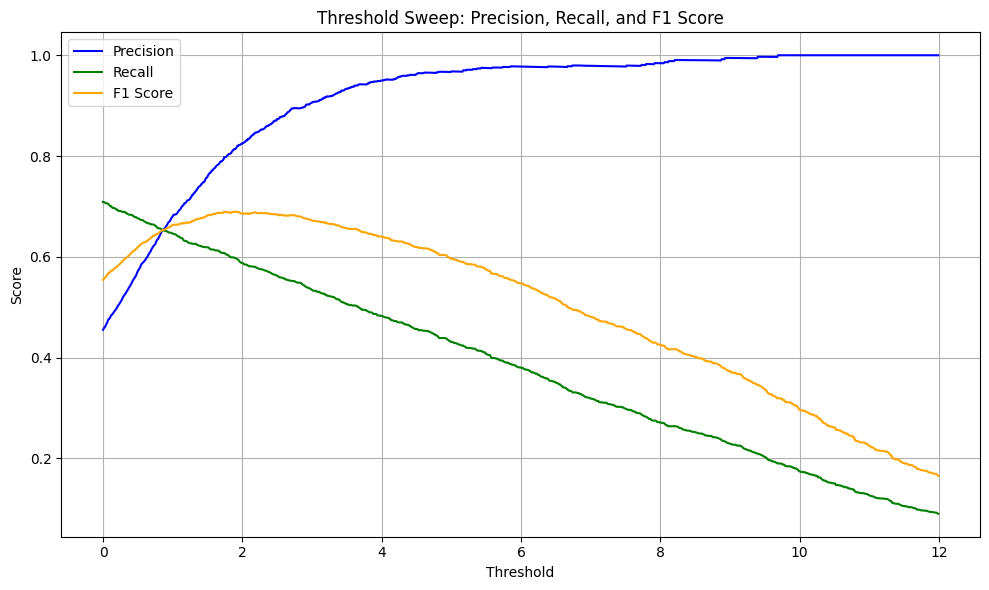

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define threshold range
thresholds = np.arange(0.0, 12, 0.01)

# Store results
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through thresholds
for t in thresholds:
    preds = (merged_df['BUZZ_pred'] >= t).astype(int)
    precision_scores.append(precision_score(merged_df['true_label'], preds))
    recall_scores.append(recall_score(merged_df['true_label'], preds))
    f1_scores.append(f1_score(merged_df['true_label'], preds))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep: Precision, Recall, and F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Optimize F1 value.

Optimal Threshold: 1.74
Max F1 Score: 0.69


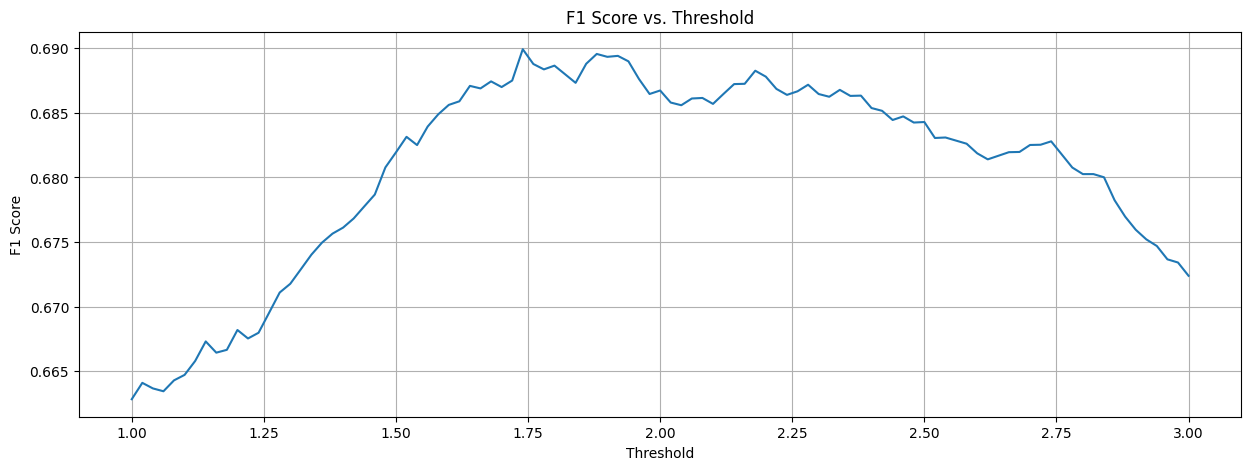

In [50]:
import numpy as np
from sklearn.metrics import f1_score

# Define a range of thresholds to test (from 0 to 1)
thresholds = np.linspace(1, 3, 101)

# Initialize a list to store F1 scores for each threshold
f1_scores = []

# Iterate over all thresholds and calculate the F1 score for each
for threshold in thresholds:
    predicted_labels = (merged_df['BUZZ_pred'] >= threshold).astype(int)
    f1 = f1_score(merged_df['true_label'], predicted_labels)
    f1_scores.append(f1)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
max_f1_score = np.max(f1_scores)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max F1 Score: {max_f1_score:.2f}")

# Plot F1 score vs. threshold
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

Plot Precision vs Recall and F1 stat.

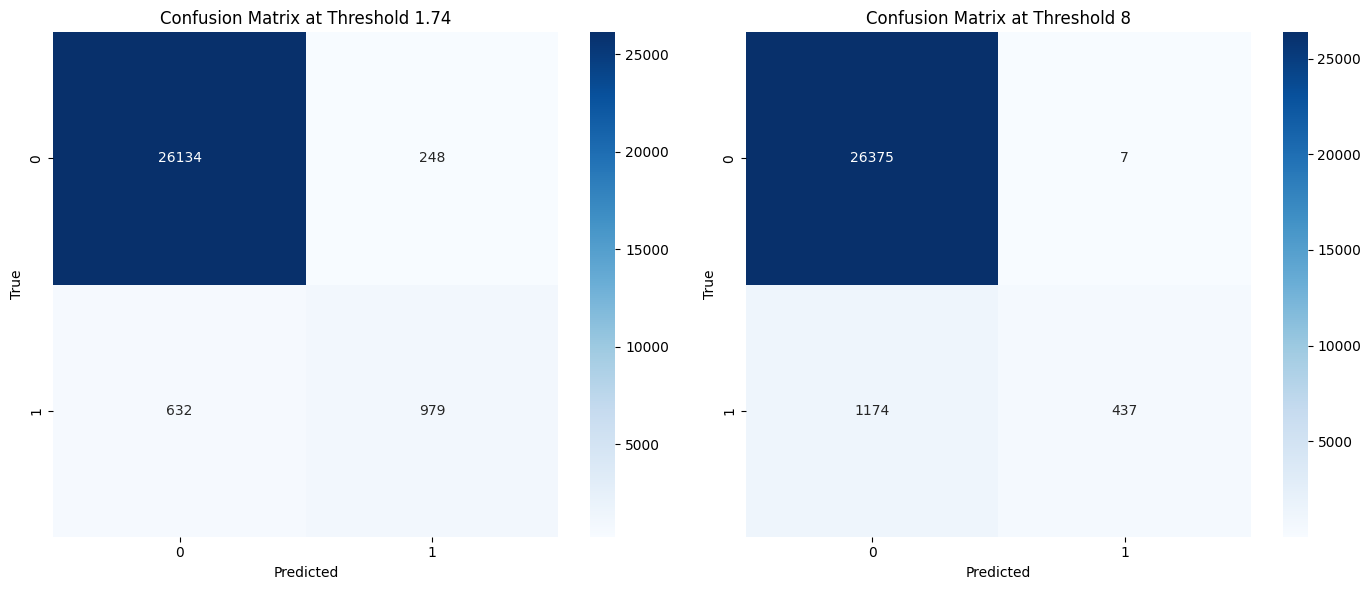

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set two different thresholds
threshold_1 = 1.74
threshold_2 = 8

# Convert predicted labels based on thresholds
pred_1 = (merged_df['BUZZ_pred'] >= threshold_1).astype(int)
pred_2 = (merged_df['BUZZ_pred'] >= threshold_2).astype(int)

# Calculate confusion matrices
cm_1 = confusion_matrix(merged_df['true_label'], pred_1)
cm_2 = confusion_matrix(merged_df['true_label'], pred_2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix at Threshold 1
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Confusion Matrix at Threshold {threshold_1}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Confusion Matrix at Threshold 2
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion Matrix at Threshold {threshold_2}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

Show histogram of scores according to label.

F1 Score: 0.689922480620155
Precision: 0.797881010594947
Recall: 0.6076970825574177


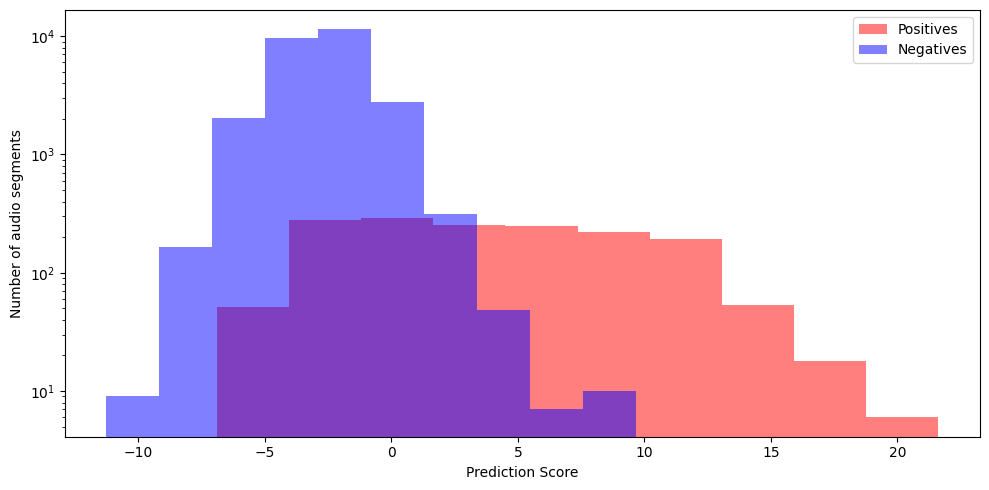

In [59]:
# Function to evaluate model's performance with F1, Precision, and Recall
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Convert to binary prediction based on threshold
threshold = 1.74  # Choose your threshold
merged_df['predicted_label'] = (merged_df['BUZZ_pred'] >= threshold).astype(int)

# Ensure the true labels are also integers
merged_df['true_label'] = merged_df['true_label'].astype(int)

# Evaluate model performance
f1 = f1_score(merged_df['true_label'], merged_df['predicted_label'])
print('F1 Score:', f1)

precision = precision_score(merged_df['true_label'], merged_df['predicted_label'])
print('Precision:', precision)

recall = recall_score(merged_df['true_label'], merged_df['predicted_label'])
print('Recall:', recall)

# Optionally, you could also compute mAP if needed
# mAP = average_precision_score(merged_df['true_label'], merged_df['BUZZ_pred'])
# print('mAP:', mAP)

# Plot histograms for positive and negative predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Get the positive and negative predictions
positives = merged_df['true_label'] == 1
negatives = merged_df['true_label'] == 0

# Plot histograms for the positive and negative predictions
ax.hist(merged_df['BUZZ_pred'][positives], alpha=0.5, color="red", label="Positives")
ax.hist(merged_df['BUZZ_pred'][negatives], alpha=0.5, color="blue", label="Negatives")

# Set log scale for y-axis
ax.set_yscale("log")

# Labeling axes
ax.set_ylabel("Number of audio segments")
ax.set_xlabel("Prediction Score")

# Add a legend
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()